In [256]:
# basic
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt
%matplotlib inline

# preprocess
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import KFold

# models
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge
# model tensorflow
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ReLU, PReLU
from keras.optimizers import SGD, Adam

# optimizer
from functools import partial
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import mean_squared_error as MSE, make_scorer

# importance
import eli5
from eli5.sklearn import PermutationImportance

# other
import pickle
import time
import datetime
#import sys
#import gc

In [26]:
sample_sub = pd.read_csv('../data/input/sample_submit.csv', header=None, names=['id', 'mpg'])

In [27]:
train = pd.read_csv('../data/input/train.csv')
test = pd.read_csv('../data/input/test.csv')
sample_sub = pd.read_csv('../data/input/sample_submit.csv', header=None, names=['id', 'mpg'])

train_test = pd.concat([train, test], ignore_index=True, sort=False)

# Preprocess

In [28]:
train_test['car name'] = train_test['car name'].str.replace('vw', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('vokswagen', 'volkswagen')
train_test['car name'] = train_test['car name'].str.replace('toyouta', 'toyota')
train_test['car name'] = train_test['car name'].str.replace('chevy', 'chevrolet')
train_test['car name'] = train_test['car name'].str.replace('datsun 200-sx', 'datsun 200sx')

train_test['car name'] = train_test['car name'].str.replace('datsun 210 mpg', 'datsun 210')
train_test['car name'] = train_test['car name'].str.replace('ford gran torino (sw)', 'ford gran torino')

train_test['car_brand'] = train_test['car name'].apply(lambda x: x.strip().split(' ')[0])

In [29]:
train_test['horsepower'].replace('?', np.nan, inplace=True)
train_test['horsepower'] = train_test['horsepower'].astype(float)

# car name毎のhorse powerの平均値を計算(nanは計算外)
name_hp_mean = train_test.groupby('car name').horsepower.mean()
df_hp_isnull = train_test[train_test['horsepower'].isnull()]

# nan位置のtrainデータのhorse powerを置換する
for i in df_hp_isnull.index:
    train_test.loc[i, 'horsepower'] = name_hp_mean[df_hp_isnull.loc[i, 'car name']]
    
del df_hp_isnull, name_hp_mean

## Drop unimportant features

# train_test.drop(['car name', 'car_brand'], axis=1, inplace=True)
display(train_test)

## Standard Scaler

In [30]:
train_test_svr = train_test.copy()

cols = ['displacement', 'horsepower', 'acceleration']
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
train_test_svr[cols] = scaler.fit_transform(train_test_svr[cols])
display(train_test_svr)

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,car_brand
0,0,23.059782,6,-0.483685,0.143900,2815,1.195071,80,1,dodge aspen,dodge
1,3,17.674521,8,1.521800,1.333045,4456,-0.797646,72,1,dodge rampage,dodge
2,4,17.136353,8,1.063404,1.035759,2774,-0.933663,79,1,mercury cougar brougham,mercury
3,7,22.664666,6,1.999297,-0.599315,2190,-0.046689,71,1,pontiac j2000 se hatchback,pontiac
4,9,17.872018,8,2.276245,3.414047,2245,-2.535961,70,1,ford galaxie 500,ford
...,...,...,...,...,...,...,...,...,...,...,...
995,992,NaN,4,0.328059,-0.004743,3870,0.033651,76,1,chevrolet nova,chevrolet
996,993,NaN,4,-0.483685,0.203358,2720,-0.751965,82,1,buick century limited,buick
997,996,NaN,8,1.216202,0.143900,2774,-0.905656,75,1,ford ltd,ford
998,998,NaN,4,-0.961181,-0.896601,2807,1.112525,77,1,dodge monaco brougham,dodge


# Encoding

In [31]:
cat_cols = ['cylinders', 'model year', 'origin', 'car name', 'car_brand']
train_test_svr = pd.get_dummies(
    train_test_svr,
    columns=cat_cols, 
    sparse=False
)

display(train_test_svr)

cat_cols = ['car name', 'car_brand']
for cols in cat_cols:
    train_test[cols] = LabelEncoder().fit_transform(train_test[cols])

display(train_test)

,id,mpg,displacement,horsepower,weight,acceleration,cylinders_4,cylinders_6,cylinders_8,model year_70,...,car_brand_opel,car_brand_peugeot,car_brand_plymouth,car_brand_pontiac,car_brand_renault,car_brand_saab,car_brand_toyota,car_brand_triumph,car_brand_volkswagen,car_brand_volvo
0,0,23.059782,-0.483685,0.143900,2815,1.195071,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,17.674521,1.521800,1.333045,4456,-0.797646,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,4,17.136353,1.063404,1.035759,2774,-0.933663,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,7,22.664666,1.999297,-0.599315,2190,-0.046689,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,9,17.872018,2.276245,3.414047,2245,-2.535961,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,992,NaN,0.328059,-0.004743,3870,0.033651,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,993,NaN,-0.483685,0.203358,2720,-0.751965,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,996,NaN,1.216202,0.143900,2774,-0.905656,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
998,998,NaN,-0.961181,-0.896601,2807,1.112525,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,car_brand
0,0,23.059782,6,140,110.0,2815,17.977429,80,1,33,6
1,3,17.674521,8,350,150.0,4456,13.514535,72,1,39,6
2,4,17.136353,8,302,140.0,2774,13.209912,79,1,59,11
3,7,22.664666,6,400,85.0,2190,15.196381,71,1,72,16
4,9,17.872018,8,429,220.0,2245,9.621400,70,1,47,8
...,...,...,...,...,...,...,...,...,...,...,...
995,992,NaN,4,225,105.0,3870,15.376311,76,1,21,4
996,993,NaN,4,140,112.0,2720,13.616843,82,1,9,2
997,996,NaN,8,318,110.0,2774,13.272636,75,1,51,8
998,998,NaN,4,90,75.0,2807,17.792560,77,1,37,6


## create train, test

In [32]:
test_x = train_test[train_test['mpg'].isnull()].drop(['id', 'mpg'], axis=1).copy()
train_x = train_test.dropna(subset=['mpg'], axis=0).copy()
train_y = train_x['mpg']
train_x.drop(['id', 'mpg'], axis=1, inplace=True)

test_x_svr = train_test_svr[train_test_svr['mpg'].isnull()].drop(['id', 'mpg'], axis=1).copy()
train_x_svr = train_test_svr.dropna(subset=['mpg'], axis=0).drop(['id', 'mpg'], axis=1).copy()

print('test_x')
display(test_x.head())

print('train_y')
display(train_y)

print('train_x')
display(train_x.head())

print('test_x_svr')
display(test_x_svr.head())

print('train_x_svr')
display(train_x_svr.head())

test_x


,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,car_brand
500,4,98,67.0,2000,15.049795,81,1,65,14
501,4,97,90.0,2720,15.339172,79,1,33,6
502,4,90,75.0,2807,17.821599,77,1,37,6
503,4,140,110.0,2807,13.780354,82,2,9,2
504,4,121,85.0,3070,13.688921,73,2,75,18


train_y


0      23.059782
1      17.674521
2      17.136353
3      22.664666
4      17.872018
         ...    
495    22.798447
496    35.173640
497    17.825448
498    28.545147
499    36.011880
Name: mpg, Length: 500, dtype: float64

train_x


,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,car_brand
0,6,140,110.0,2815,17.977429,80,1,33,6
1,8,350,150.0,4456,13.514535,72,1,39,6
2,8,302,140.0,2774,13.209912,79,1,59,11
3,6,400,85.0,2190,15.196381,71,1,72,16
4,8,429,220.0,2245,9.621400,70,1,47,8


test_x_svr


,displacement,horsepower,weight,acceleration,cylinders_4,cylinders_6,cylinders_8,model year_70,model year_71,model year_72,...,car_brand_opel,car_brand_peugeot,car_brand_plymouth,car_brand_pontiac,car_brand_renault,car_brand_saab,car_brand_toyota,car_brand_triumph,car_brand_volkswagen,car_brand_volvo
500,-0.884782,-1.134430,2000,-0.112141,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
501,-0.894332,-0.450672,2720,0.017068,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502,-0.961181,-0.896601,2807,1.125491,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
503,-0.483685,0.143900,2807,-0.678956,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
504,-0.665133,-0.599315,3070,-0.719781,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


train_x_svr


,displacement,horsepower,weight,acceleration,cylinders_4,cylinders_6,cylinders_8,model year_70,model year_71,model year_72,...,car_brand_opel,car_brand_peugeot,car_brand_plymouth,car_brand_pontiac,car_brand_renault,car_brand_saab,car_brand_toyota,car_brand_triumph,car_brand_volkswagen,car_brand_volvo
0,-0.483685,0.143900,2815,1.195071,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.521800,1.333045,4456,-0.797646,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1.063404,1.035759,2774,-0.933663,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.999297,-0.599315,2190,-0.046689,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,2.276245,3.414047,2245,-2.535961,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Define Functions

In [62]:
class Model1_LGBM:

    def __init__(self, params):
        self.params = params
        self.params['max_depth'] = int(self.params['max_depth'])
        self.params['num_leaves'] = int(self.params['num_leaves'])
        self.params['min_data_in_leaf'] = int(self.params['min_data_in_leaf'])
        self.model = lgb.LGBMRegressor(**self.params)

    def fit(self, tr_x, tr_y, va_x, va_y):
        #self.params['max_depth'] = int(self.params['max_depth'])
        #self.params['num_leaves'] = int(self.params['num_leaves'])
        #self.params['min_data_in_leaf'] = int(self.params['min_data_in_leaf'])
        
        #model = lgb.LGBMRegressor(**self.params)
        #model = self.model
        self.model.fit(tr_x, tr_y)
        #self.model = model

    def predict(self, x):
        return self.model.predict(x)

In [221]:
class Model1_RF:
    
    def __init__(self, params):
        params['n_estimators'] = int(params['n_estimators'])
        params['max_depth'] = int(params['max_depth'])
        params['min_samples_split'] = int(params['min_samples_split'])
        #params['min_samples_leaf'] = int(params['min_samples_leaf'])
        
        self.params = params
        self.model = RandomForestRegressor(**self.params)
        
    def fit(self, tr_x, tr_y, va_x, va_y):
        self.model.fit(tr_x, tr_y)
    
    def predict(self, x):
        return self.model.predict(x)

In [257]:
class Model1_ET:
    
    def __init__(self, params):
        params['n_estimators'] = int(params['n_estimators'])
        params['max_depth'] = int(params['max_depth'])
        params['min_samples_split'] = int(params['min_samples_split'])
        #params['min_samples_leaf'] = int(params['min_samples_leaf'])
        
        self.params = params
        self.model = ExtraTreesRegressor(**self.params)
        
    def fit(self, tr_x, tr_y, va_x, va_y):
        self.model.fit(tr_x, tr_y)
    
    def predict(self, x):
        return self.model.predict(x)

In [63]:
class Model1_SVR:
    def __init__(self, params):
        self.params = params
        self.model = SVR(**self.params)

    def fit(self, tr_x, tr_y, va_x, va_y):
        self.model.fit(tr_x, tr_y)
        #self.model = model
    
    def predict(self, x):
        return self.model.predict(x)

In [64]:
class Model1_NN:

    def __init__(self, params):
        self.params = params       

        # Layer Setting
        self.model = Sequential()
        self.model.add(Dropout(self.params['input_dropout'], input_shape=(train_x.shape[1],)))# 入力層
        for i in range(int(self.params['hidden_layers'])):# 中間層
            self.model.add(Dense(int(self.params['hidden_units'])))
            if self.params['batch_norm'] == 'before_act':
                self.model.add(BatchNormalization())
            if self.params['hidden_activation'] == 'prelu':
                self.model.add(PReLU())
            elif self.params['hidden_activation'] == 'relu':
                self.model.add(ReLU())
            else:
                raise NotImplementedError
            self.model.add(Dropout(self.params['input_dropout']))
        self.model.add(Dense(1))# 出力層

        # オプティマイザ
        if self.params['optimizer']['type'] == 'sgd':
            optimizer = SGD(lr=self.params['optimizer']['lr'], decay=1e-6, momentum=0.9, nesterov=True)
        elif self.params['optimizer']['type'] == 'adam':
            optimizer = Adam(lr=self.params['optimizer']['lr'], beta_1=0.9, beta_2=0.999, decay=0.)
        else:
            raise NotImplementedError

        # 目的関数、評価指標などの設定
        self.model.compile(loss='mean_squared_error',
                           optimizer=optimizer, metrics=['mse'])
        
    def fit(self, tr_x, tr_y, va_x, va_y):
        # 標準化
        self.scaler = StandardScaler()
        tr_x = self.scaler.fit_transform(tr_x)
        va_x = self.scaler.transform(va_x)        

        # エポック数、アーリーストッピング
        # あまりepochを大きくすると、小さい学習率のときに終わらないことがあるので注意
        nb_epoch = 200
        patience = 20
        early_stopping = EarlyStopping(patience=patience, restore_best_weights=True)

        # 学習の実行
        history = self.model.fit(tr_x, tr_y,
                                 epochs=nb_epoch,
                                 batch_size=int(self.params['batch_size']), verbose=0,
                                 validation_data=(va_x, va_y),
                                 callbacks=[early_stopping])

    def predict(self, x):
        # 予測
        x = self.scaler.transform(x)
        y_pred = self.model.predict(x)
        y_pred = y_pred.flatten()
        return y_pred


In [70]:
# 線形モデル
class Model2_Ridge:

    def __init__(self, params):
        self.params = params
        self.model = Ridge(**self.params)
        self.scaler = None

    def fit(self, tr_x, tr_y, va_x, va_y):
        #self.scaler = StandardScaler()
        #self.scaler.fit(tr_x)
        #tr_x = self.scaler.transform(tr_x)
        self.model.fit(tr_x, tr_y)

    def predict(self, x):
        #x = self.scaler.transform(x)
        #pred = self.model.predict(x)
        return self.model.predict(x)

In [258]:
def RMSE(y_true, y_pred):
    return(np.sqrt(MSE(y_true, y_pred)))

def objective(x, y, args):  
    if args['model_type'] == 'lgb':
        del args['model_type']
        reg = Model1_LGBM(args)
    elif args['model_type'] == 'svr':
        del args['model_type']
        reg = Model1_SVR(args)
    elif args['model_type'] == 'nn':
        del args['model_type']
        reg = Model1_NN(args)
    elif args['model_type'] == 'rid':
        del args['model_type']
        reg = Model2_Ridge(args)
    elif args['model_type'] == 'rf':
        del args['model_type']
        reg = Model1_RF(args)
    elif args['model_type'] == 'et':
        del args['model_type']
        reg = Model1_ET(args)
    else:
        del args['model_type']
        reg = None

    scores = []
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for tr_idx, va_idx in kf.split(x, y):
        tr_x = x.iloc[tr_idx]
        tr_y = y.iloc[tr_idx]
        va_x = x.iloc[va_idx]
        va_y = y.iloc[va_idx]
        
        reg.fit(tr_x, tr_y, va_x, va_y)        
        va_pred = reg.predict(va_x)
        score = RMSE(va_y, va_pred)
        scores.append(score)
        
    return {
        #'loss':cv_result['test_score'].mean(),
        'loss': np.mean(scores),
        'status':STATUS_OK,
        'params':args
    }

# HyperOpt

## LightGBM

In [229]:
params_lgb = {
    'model_type': 'lgb',
    'alpha' : 2.75e-06, #hp.loguniform(label='alpha', low=np.log(1e-8), high=np.log(0.2)),
    'bagging_fraction': hp.quniform(label='bagging_fraction', low=0.4, high=0.80, q=0.05),
    'feature_fraction': hp.quniform(label='feature_fraction', low=0.4, high=0.7, q=0.05),
    'gamma': hp.quniform(label='gamma', low=0.1, high=0.7, q=0.1),
    'lambda' : hp.loguniform(label='lambda', low=np.log(1e-6), high=np.log(0.6)),
    'max_depth': hp.quniform(label='max_depth', low=5, high=13, q=1),
    'min_child_weight': hp.quniform(label='min_child_weight', low=1, high=5, q=1),
    'min_data_in_leaf':6, # hp.quniform(label='min_data_in_leaf', low=5, high=10, q=2),
    'num_leaves': hp.quniform(label='num_leaves', low=10, high=40, q=10)
}

f_lgb = partial(objective, train_x, train_y)
trials_lgb = Trials()

best_lgb = fmin(
    fn=f_lgb,
    space=params_lgb,
    algo=tpe.suggest,
    trials=trials_lgb,
    max_evals=500
)

100%|███████████████████████████████████████████████| 500/500 [02:02<00:00,  4.08trial/s, best loss: 2.739827551265387]


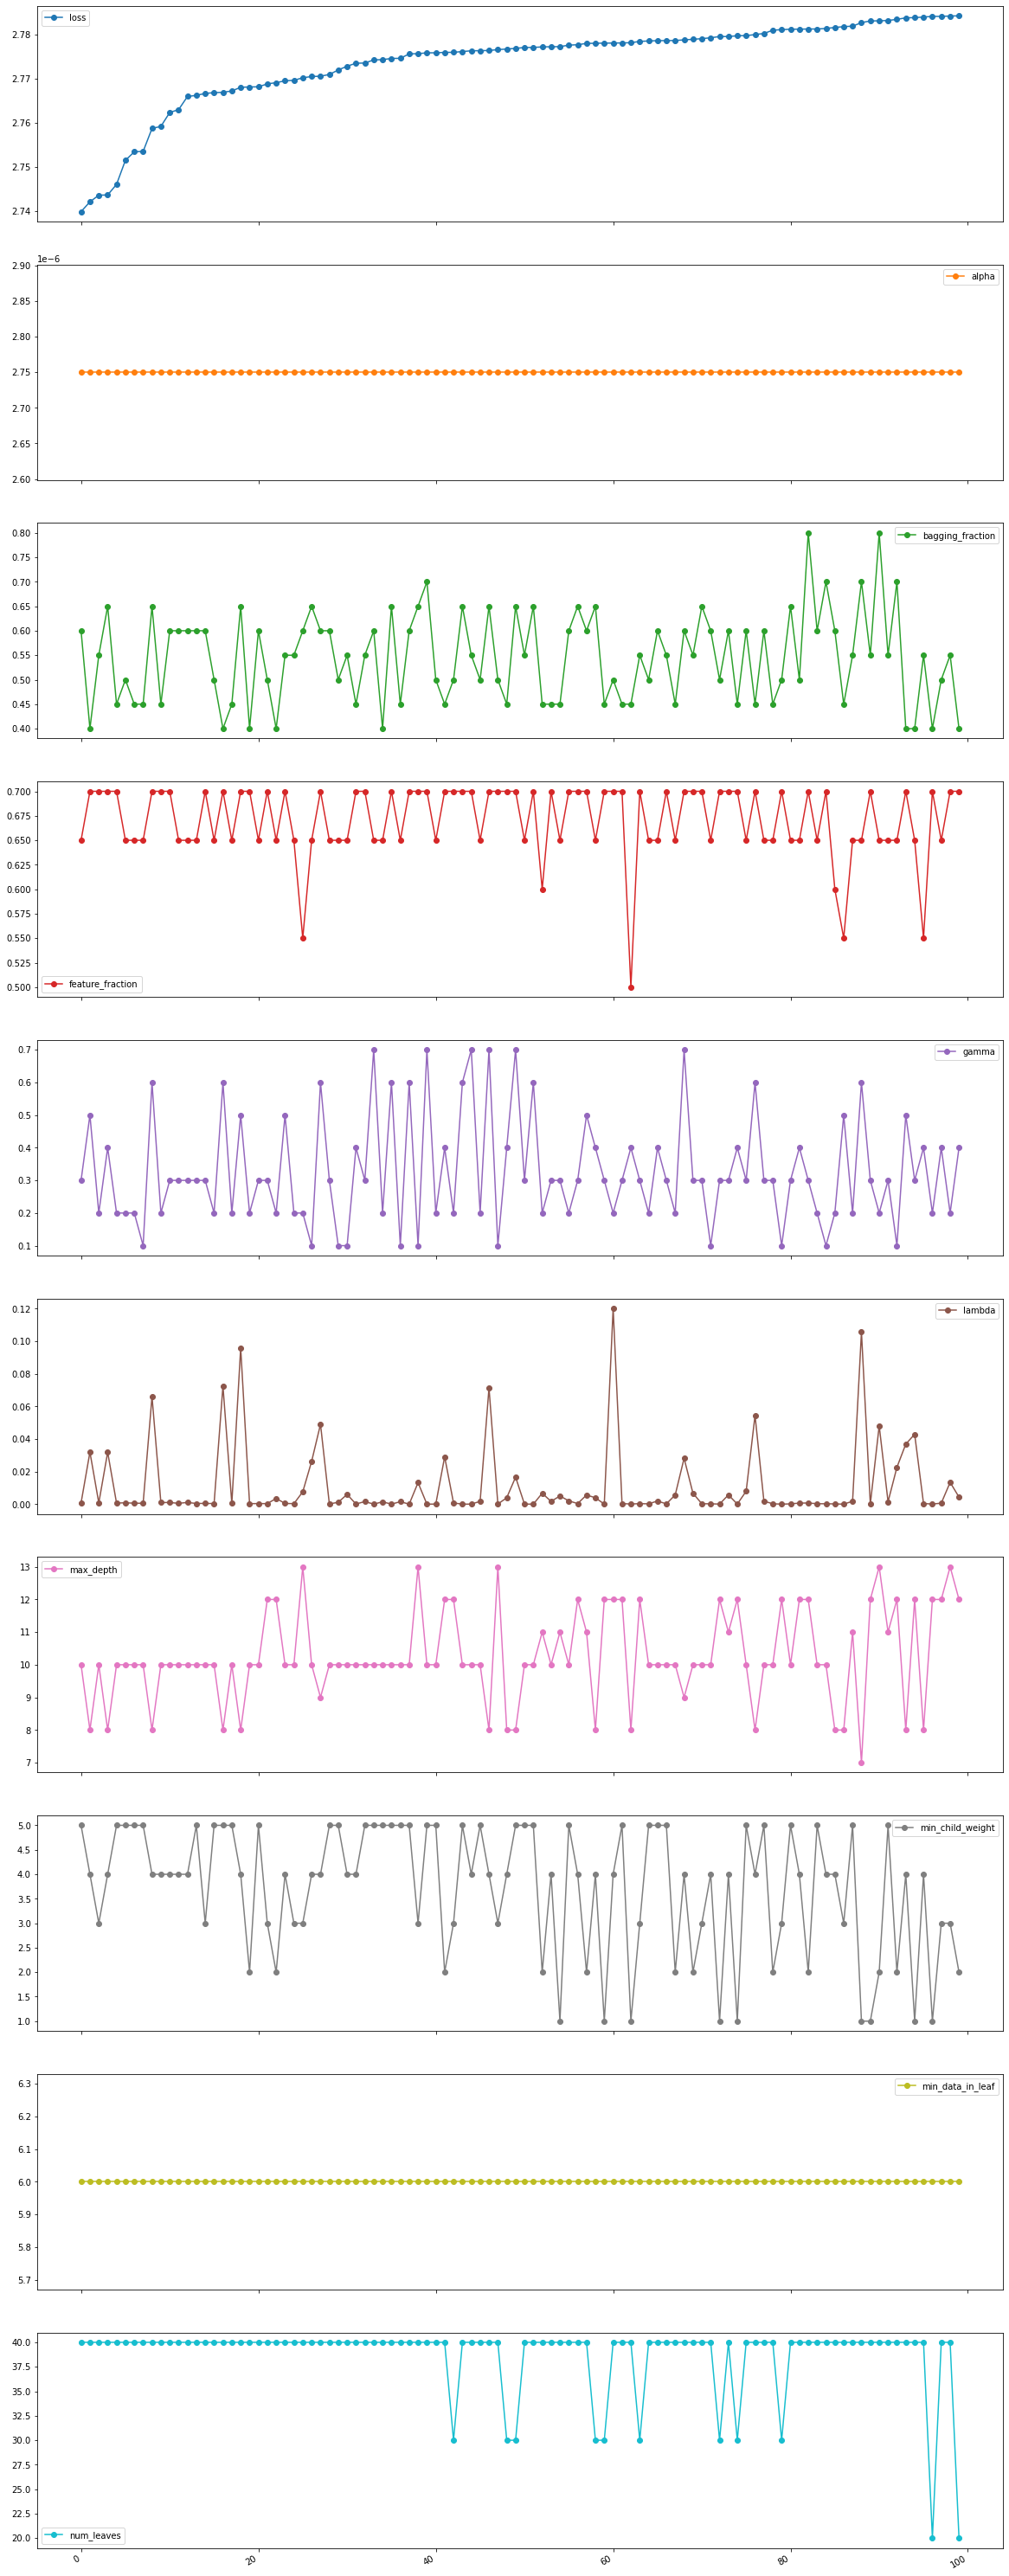

In [230]:
# trialsからスコアとパラメータを取り出し
result_lgb = [(i['loss'], i['params']) for i in sorted(trials_lgb.results, key=lambda x: x['loss'])]
# スコアとパラメータそれぞれをリスト、辞書に
losses_lgb = [i[0] for i in result_lgb]
opt_params_lgb = [i[1] for i in result_lgb]
# スコアとパラメータをDataFrame化
opt_params_df_lgb = pd.concat(
    [pd.Series(losses_lgb, name='loss'), 
     pd.DataFrame(opt_params_lgb)],
    axis=1)

opt_params_df_lgb.iloc[:100].plot.line(
    figsize=(20, 60), layout=(10, 1), marker='o', subplots=True, legend=True
)
plt.show()

## SVR

In [232]:
params_svr = {
    'model_type': 'svr',
    'kernel': 'rbf',
    'C': hp.loguniform(
        label='C', low=np.log(1), high=np.log(30)
    ),
    'epsilon':hp.loguniform(
        label='epsilon', low=np.log(0.5), high=np.log(1.5)
    ),
    'gamma': hp.loguniform(
        label='gamma', low=np.log(0.01), high=np.log(0.3)
    )
}

f_svr = partial(objective, train_x_svr, train_y)
trials_svr = Trials()

best_svr = fmin(
    fn=f_svr,
    space=params_svr,
    algo=tpe.suggest,
    trials=trials_svr,
    max_evals=500
)

100%|██████████████████████████████████████████████| 500/500 [01:16<00:00,  6.51trial/s, best loss: 3.7466100440636483]


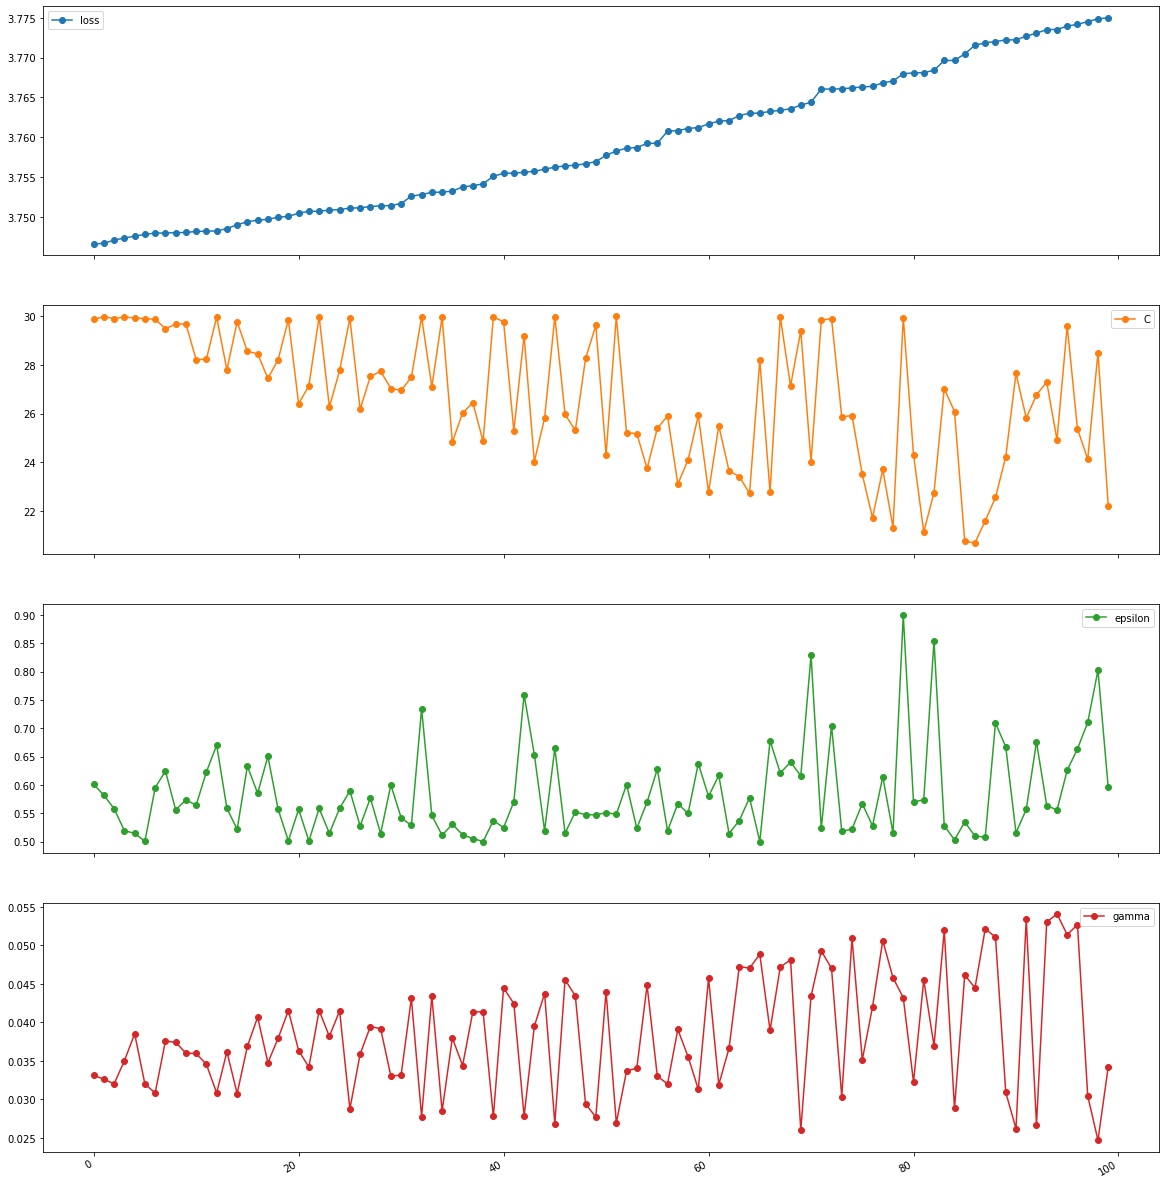

In [233]:
# trialsからスコアとパラメータを取り出し
result_svr = [(i['loss'], i['params']) for i in sorted(trials_svr.results, key=lambda x: x['loss'])]
# スコアとパラメータそれぞれをリスト、辞書に
losses_svr = [i[0] for i in result_svr]
opt_params_svr = [i[1] for i in result_svr]
# スコアとパラメータをDataFrame化
opt_params_df_svr = pd.concat(
    [pd.Series(losses_svr, name='loss'), 
     pd.DataFrame(opt_params_svr)],
    axis=1)

opt_params_df_svr.iloc[:100].plot.line(
    figsize=(20, 60), layout=(10, 1), marker='o', subplots=True, legend=True
)
plt.show()

# Random Forest

In [254]:
params_rf = {
    'model_type': 'rf',
    'max_depth': hp.quniform(label='max_depth', low=5, high=15, q=1),
    'min_samples_split': hp.quniform(label='min_samples_split', low=2, high=8, q=1),
    #'min_samples_leaf': hp.quniform(label='min_samples_leaf', low=1, high=5, q=1),
    'n_estimators': hp.quniform(label='n_estimators', low=10, high=100, q=5),
    'bootstrap': True
}

max_evals = 500
trials_rf = Trials()
f_rf = partial(objective, train_x, train_y)

best = fmin(
    fn=f_rf, 
    space=params_rf, 
    algo=tpe.suggest, 
    trials=trials_rf,
    max_evals=max_evals
)

100%|████████████████████████████████████████████████| 500/500 [04:44<00:00,  1.76trial/s, best loss: 2.95809079118086]


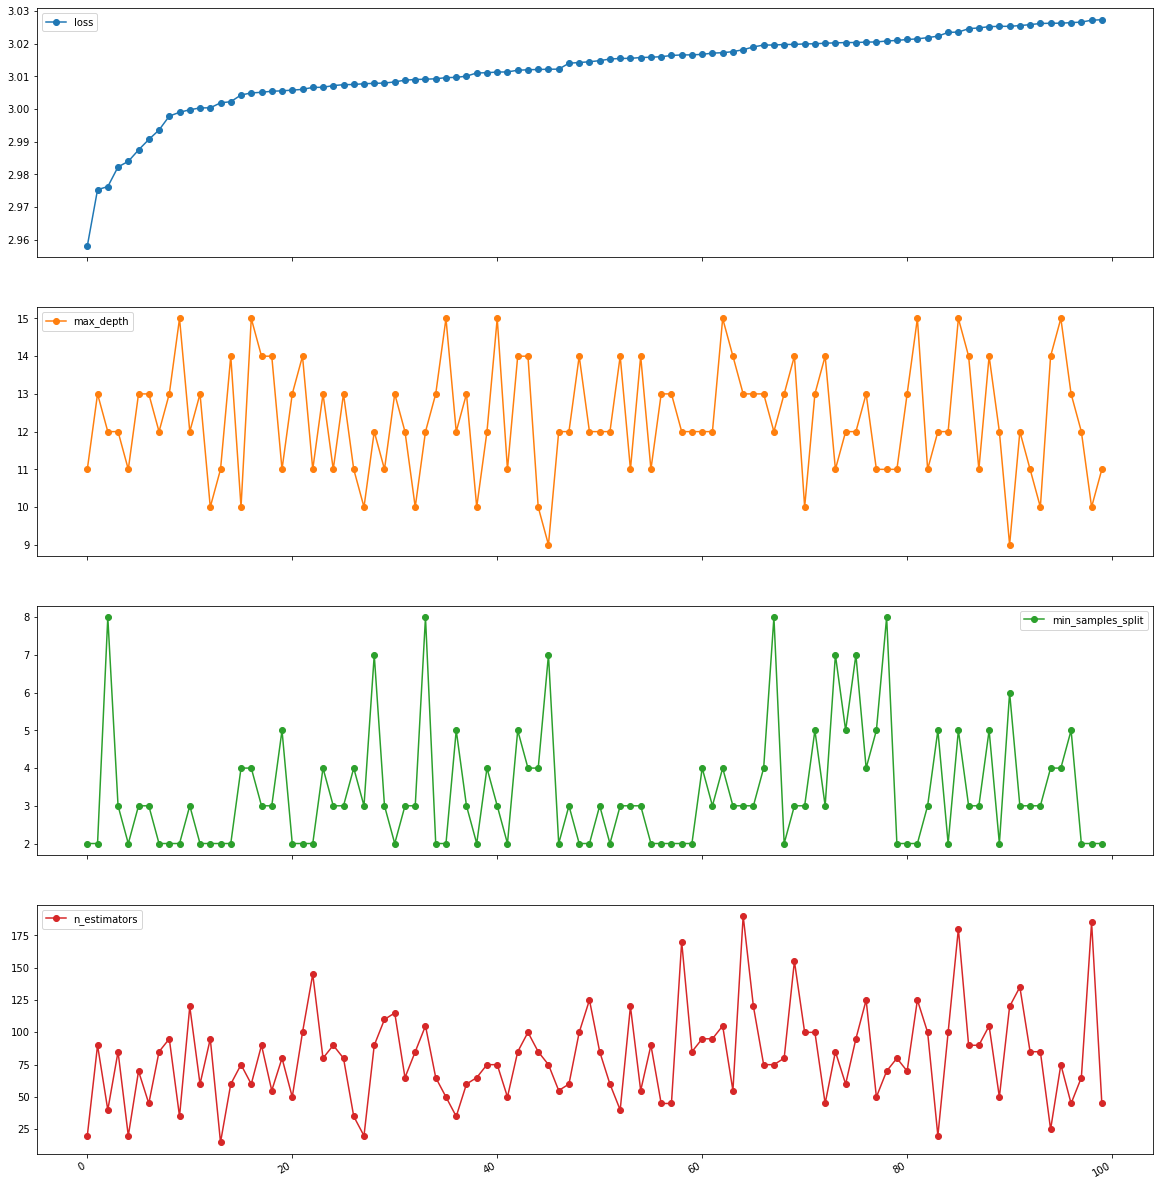

In [255]:
# trialsからスコアとパラメータを取り出し
result_rf = [(i['loss'], i['params']) for i in sorted(trials_rf.results, key=lambda x: x['loss'])]
# スコアとパラメータそれぞれをリスト、辞書に
losses_rf = [i[0] for i in result_rf]
opt_params_rf = [i[1] for i in result_rf]
# スコアとパラメータをDataFrame化
opt_params_df_rf = pd.concat(
    [pd.Series(losses_rf, name='loss'), 
     pd.DataFrame(opt_params_rf)],
    axis=1)

opt_params_df_rf.iloc[:100].plot.line(
    figsize=(20, 60), layout=(10, 1), marker='o', subplots=True, legend=True
)
plt.show()

# Extra Trees Regression

In [259]:
params_et = {
    'model_type': 'et',
    'max_depth': hp.quniform(label='max_depth', low=5, high=15, q=1),
    'min_samples_split': hp.quniform(label='min_samples_split', low=2, high=8, q=1),
    #'min_samples_leaf': hp.quniform(label='min_samples_leaf', low=1, high=5, q=1),
    'n_estimators': hp.quniform(label='n_estimators', low=10, high=100, q=5),
    'bootstrap': True
}

max_evals = 500
trials_et = Trials()
f_et = partial(objective, train_x, train_y)

best = fmin(
    fn=f_et, 
    space=params_et, 
    algo=tpe.suggest, 
    trials=trials_et,
    max_evals=max_evals
)

100%|███████████████████████████████████████████████| 500/500 [02:27<00:00,  3.38trial/s, best loss: 2.917580633376338]


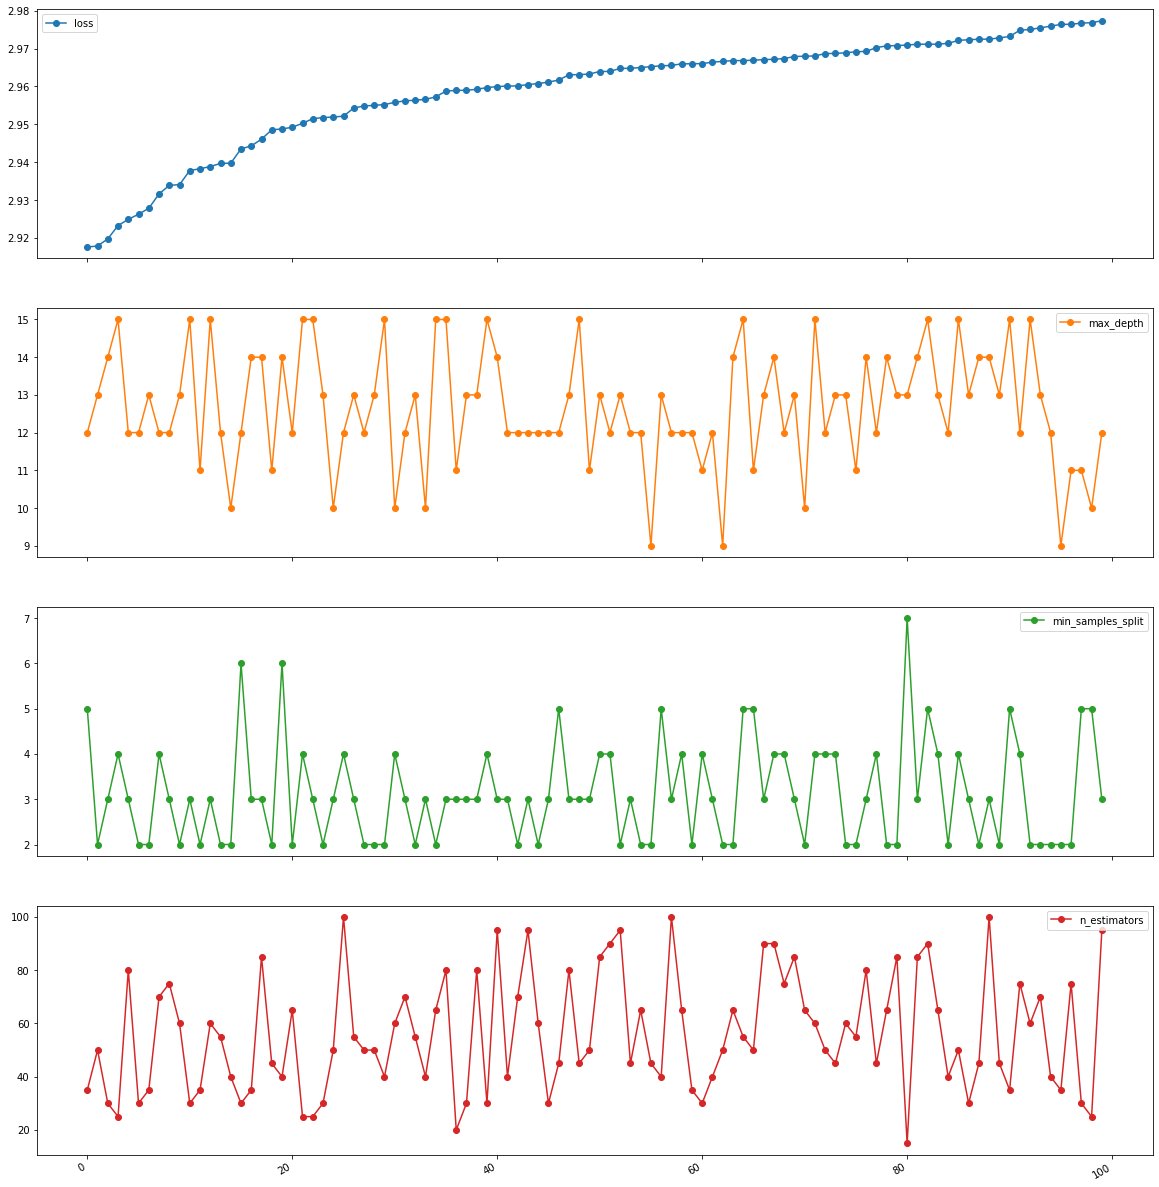

In [260]:
# trialsからスコアとパラメータを取り出し
result_et = [(i['loss'], i['params']) for i in sorted(trials_et.results, key=lambda x: x['loss'])]
# スコアとパラメータそれぞれをリスト、辞書に
losses_et = [i[0] for i in result_et]
opt_params_et = [i[1] for i in result_et]
# スコアとパラメータをDataFrame化
opt_params_df_et = pd.concat(
    [pd.Series(losses_et, name='loss'), 
     pd.DataFrame(opt_params_et)],
    axis=1)

opt_params_df_et.iloc[:100].plot.line(
    figsize=(20, 60), layout=(10, 1), marker='o', subplots=True, legend=True
)
plt.show()

## Neural Network

In [51]:
params_nn ={
    'model_type': 'nn',
    'batch_norm': hp.choice(
        label='batch_norm', options=['no'], 
    ),
    'batch_size': hp.quniform(label='batch_size', low=10, high=100, q=16),
    'hidden_activation': hp.choice(label='hidden_activation', options=['prelu', 'relu']),
    'hidden_dropout': hp.quniform(label='hidden_dropout', low=0.025, high=0.5, q=0.05),
    'hidden_layers': 4,#hp.quniform(label='hidden_layers', low=3, high=4, q=1),
    'hidden_units': hp.quniform(label='hidden_units', low=200, high=350, q=16),
    'input_dropout': hp.quniform(label='input_dropout', low=0.001, high=0.3, q=0.025),
    'optimizer': hp.choice(
        label='optimizer',
        options=[{'type': 'adam',
                  'lr': hp.loguniform(
                      label='adam_lr', low=np.log(0.0001), high=np.log(0.01)
                  )},
                 #{'type': 'sgd', 
                 #'lr': hp.loguniform('sgd_lr', np.log(0.00001), np.log(0.01))}
                ])
}

max_evals = 50
trials_nn = Trials()
f_nn = partial(objective, train_x, train_y)

best = fmin(
    fn=f_nn, 
    space=params_nn, 
    algo=tpe.suggest, 
    trials=trials_nn,
    max_evals=max_evals
)

100%|████████████████████████████████████████████████| 50/50 [09:31<00:00, 11.44s/trial, best loss: 2.1838837357023926]


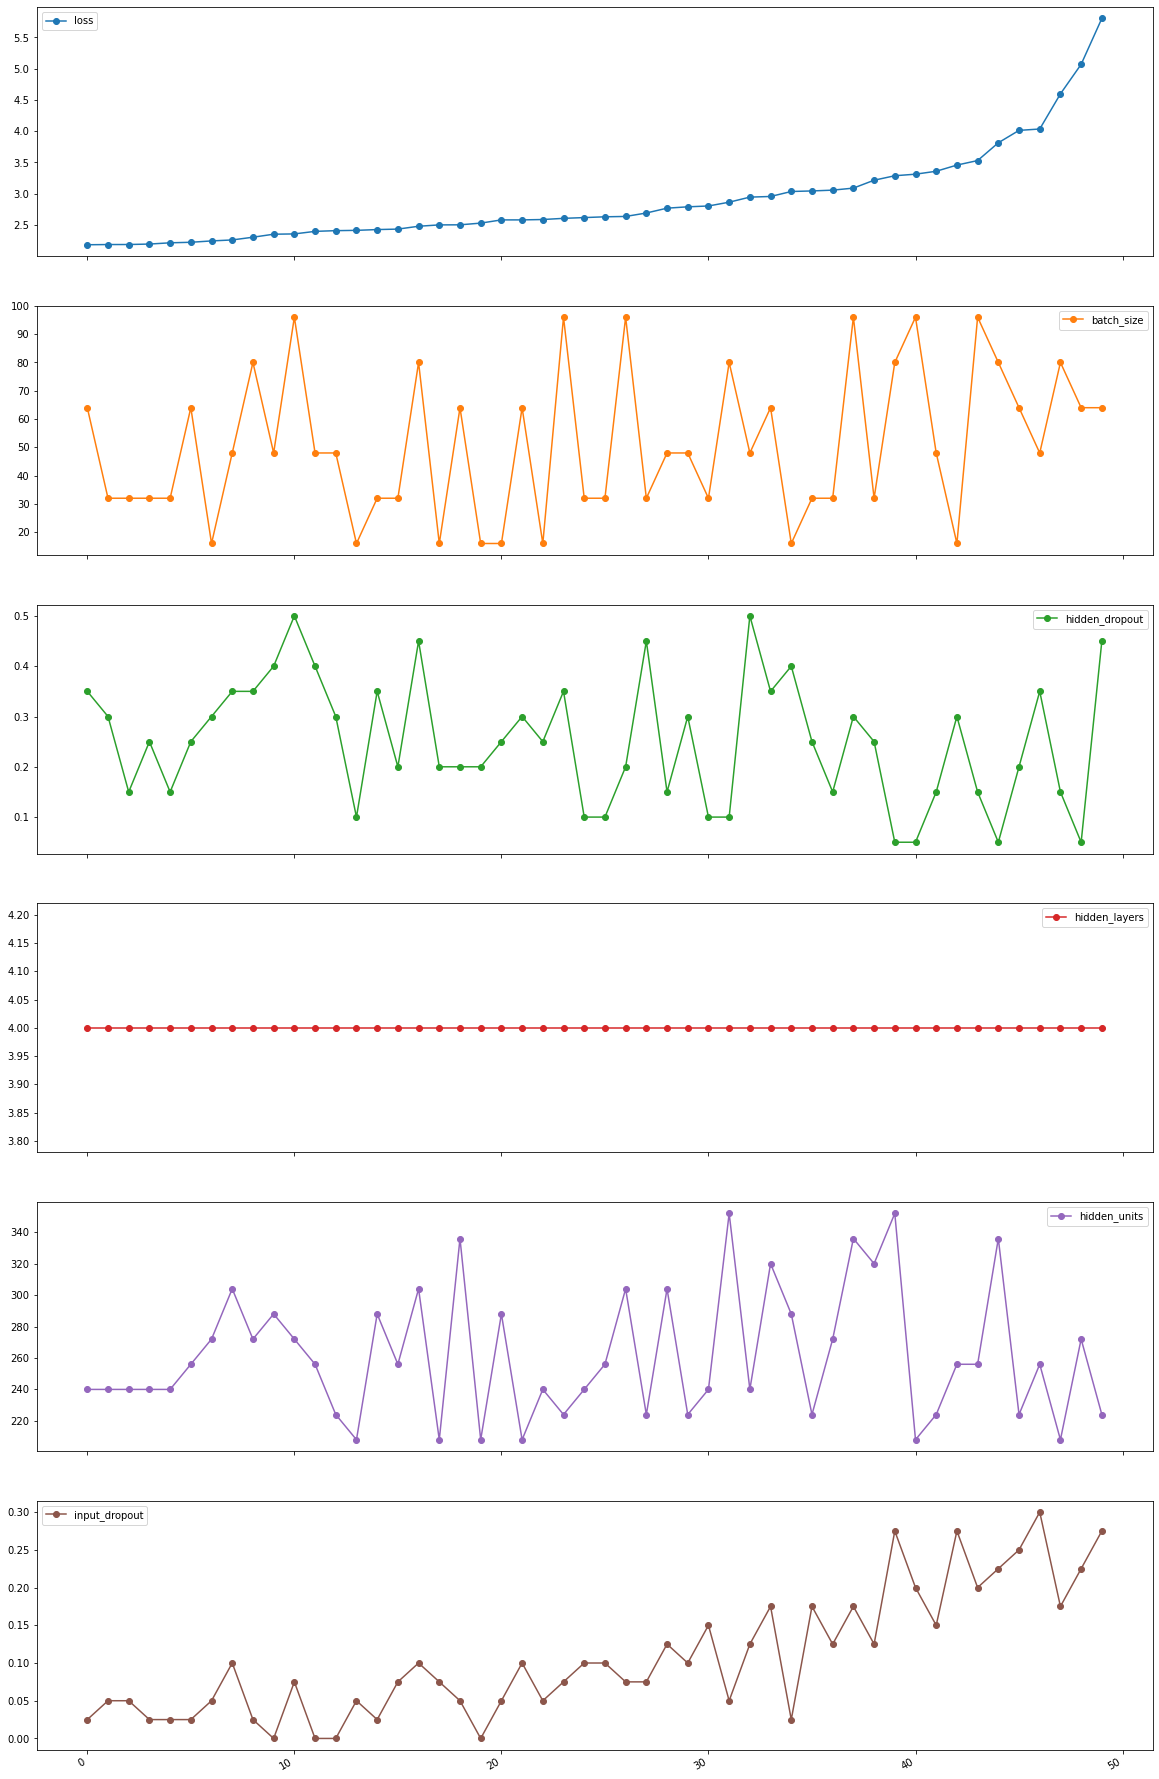

In [52]:
# trialsからスコアとパラメータを取り出し
result_nn = [(i['loss'], i['params']) for i in sorted(trials_nn.results, key=lambda x: x['loss'])]
# スコアとパラメータそれぞれをリスト、辞書に
losses_nn = [i[0] for i in result_nn]
opt_params_nn = [i[1] for i in result_nn]
# スコアとパラメータをDataFrame化
opt_params_df_nn = pd.concat(
    [pd.Series(losses_nn, name='loss'), 
     pd.DataFrame(opt_params_nn)],
    axis=1)

opt_params_df_nn.iloc[:100, :].plot.line(
    figsize=(20, 60), layout=(10, 1), marker='o', subplots=True, legend=True
)
plt.show()

# dt = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

# features
train_test.to_pickle('../features/feature_train-test_' + dt + '.pkl')
train_test_svr.to_pickle('../features/feature_train-test_' + dt + '_svr.pkl')

# best parameter
pickle.dump(opt_params_lgb[0], open('../logs/params_' + dt + '_lgb.pickle', 'wb'))
pickle.dump(opt_params_svr[0], open('../logs/params_' + dt + '_svr.pickle', 'wb'))
#pickle.dump(opt_params_nn[0], open('../logs/params_' + dt + '_nn.pickle', 'wb'))
pickle.dump(opt_params_rf[0], open('../logs/params_' + dt + '_rf.pickle', 'wb'))
# best train score
pickle.dump(losses_lgb[0], open('../logs/train_score_' + dt + '_lgb.pickle', 'wb'))
pickle.dump(losses_svr[0], open('../logs/train_score_' + dt + '_svr.pickle', 'wb'))
#pickle.dump(losses_nn[0], open('../logs/train_score_' + dt + '_nn.pickle', 'wb'))
pickle.dump(losses_rf[0], open('../logs/train_score_' + dt + '_rf.pickle', 'wb'))

# Stacking

In [235]:
def predict_cv(model, train_x, train_y, test_x):
    preds = []
    preds_test = []
    va_idxes = []
    
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    
    for i, (tr_idx, va_idx) in enumerate(kf.split(train_x)):
        tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
        tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
        
        model.fit(tr_x, tr_y, va_x, va_y)
        pred = model.predict(va_x)
        preds.append(pred)
        
        pred_test = model.predict(test_x)
        preds_test.append(pred_test)
        
        va_idxes.append(va_idx)
    
    va_idxes = np.concatenate(va_idxes)
    preds = np.concatenate(preds, axis=0)
    order = np.argsort(va_idxes)
    pred_train = preds[order]
    
    preds_test = np.mean(preds_test, axis=0)
    
    return pred_train, preds_test

In [261]:
model_1a = Model1_LGBM(params=opt_params_lgb[0])
model_1b = Model1_SVR(params=opt_params_svr[0])
#model_1c = Model1_NN(params=opt_params_nn[0])
model_1d = Model1_RF(params=opt_params_rf[0])
model_1e = Model1_ET(params=opt_params_et[0])

pred_train_1a, pred_test_1a = predict_cv(model_1a, train_x, train_y, test_x)
pred_train_1b, pred_test_1b = predict_cv(model_1b, train_x_svr, train_y, test_x_svr)
#pred_train_1c, pred_test_1c = predict_cv(model_1c, train_x, train_y, test_x)
pred_train_1d, pred_test_1d = predict_cv(model_1d, train_x, train_y, test_x)
pred_train_1e, pred_test_1e = predict_cv(model_1e, train_x, train_y, test_x)

In [262]:
score_1a = RMSE(train_y, pred_train_1a)
score_1b = RMSE(train_y, pred_train_1b)
#score_1c = RMSE(train_y, pred_train_1c)
score_1d = RMSE(train_y, pred_train_1d)
score_1e = RMSE(train_y, pred_train_1e)
print(f'model_1a(lgb) score: {score_1a:.4f}')
print(f'model_1b(svr) score: {score_1b:.4f}')
#print(f'model_1x(nn) score: {score_1c:.4f}')
print(f'model_1d(rf) score: {score_1d:.4f}')
print(f'model_1e(et) score: {score_1e:.4f}')

model_1a(lgb) score: 2.8904
model_1b(svr) score: 3.7271
model_1d(rf) score: 2.9949
model_1e(et) score: 2.9233


In [264]:
# 予測値を特徴量としてデータフレームを作成
train_x_2 = pd.DataFrame({
    'pred_1a(lgb)': pred_train_1a, 
    'pred_1b(svr)': pred_train_1b, 
    #'pred_1c(nn)': pred_train_1c,
    'pred_1d(rf)': pred_train_1d,
    'pred_1e(et)': pred_train_1e
})
test_x_2 = pd.DataFrame({
    'pred_1a(lgb)': pred_test_1a,
    'pred_1b(svr)': pred_test_1b,
    #'pred_1c(nn)': pred_test_1c,
    'pred_1d(rf)': pred_test_1d,
    'pred_1e(et)': pred_test_1e
})
display(train_x_2.head())
display(test_x_2.head())

,pred_1a(lgb),pred_1b(svr),pred_1d(rf),pred_1e(et)
0,22.807595,23.782298,23.296475,23.331095
1,17.201865,17.133763,16.656558,16.933580
2,17.763326,18.023198,17.949894,17.797679
3,22.368935,23.534684,22.335168,22.328490
4,17.475348,17.785455,17.581932,17.352951


,pred_1a(lgb),pred_1b(svr),pred_1d(rf),pred_1e(et)
0,35.885779,35.708545,35.825457,35.621487
1,27.082559,25.948326,28.983613,29.300536
2,28.089536,27.312592,27.683536,27.928231
3,32.643533,27.337333,30.709074,29.974443
4,24.199631,23.744925,24.401940,25.950248


## HyperOpt Ridge

In [265]:
params_rid ={
    'model_type': 'rid',
    'alpha': hp.quniform(label='alpha', low=1, high=30, q=1),
    #'normalize': hp.choice(label='normalize', options=[True, False]),
    #'tol': hp.loguniform(label='tol', low=np.log(1e-8), high=np.log(1.0)),
}

max_evals = 50
trials_rid = Trials()
f_rid = partial(objective, train_x_2, train_y)

best = fmin(
    fn=f_rid, 
    space=params_rid, 
    algo=tpe.suggest, 
    trials=trials_rid,
    max_evals=max_evals
)

100%|████████████████████████████████████████████████| 50/50 [00:00<00:00, 54.82trial/s, best loss: 2.7904841605772615]


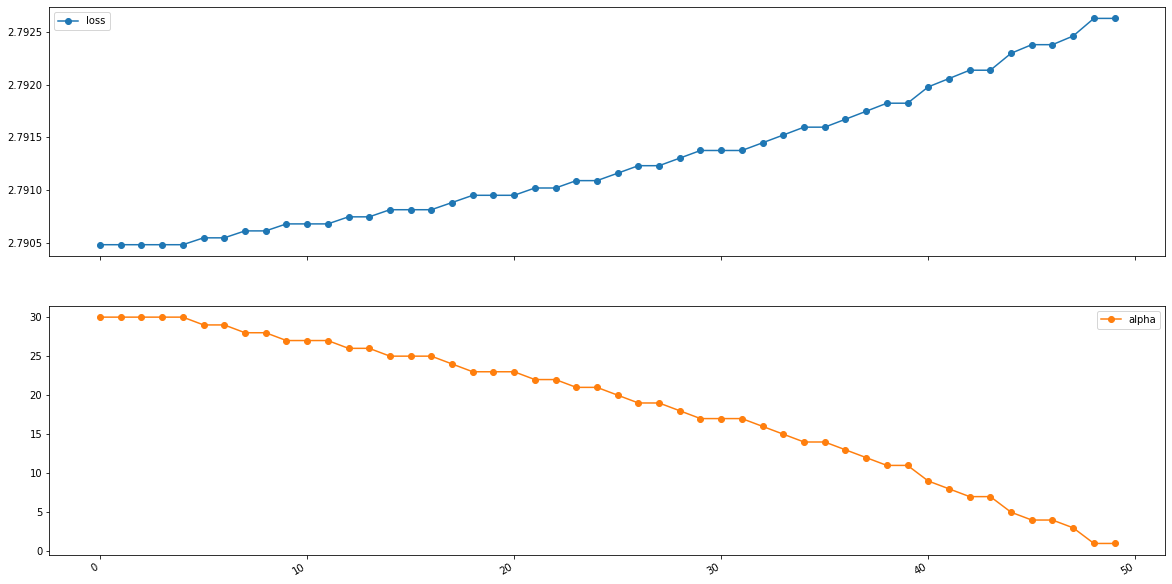

In [266]:
# trialsからスコアとパラメータを取り出し
result_rid = [(i['loss'], i['params']) for i in sorted(trials_rid.results, key=lambda x: x['loss'])]
# スコアとパラメータそれぞれをリスト、辞書に
losses_rid = [i[0] for i in result_rid]
opt_params_rid = [i[1] for i in result_rid]
# スコアとパラメータをDataFrame化
opt_params_df_rid = pd.concat(
    [pd.Series(losses_rid, name='loss'), 
     pd.DataFrame(opt_params_rid)],
    axis=1)

opt_params_df_rid.iloc[:100, :].plot.line(
    figsize=(20, 60), layout=(10, 1), marker='o', subplots=True, legend=True
)
plt.show()

In [267]:
model_2 = Model2_Ridge(params=opt_params_rid[0])
pred_train_2, pred_test_2 = predict_cv(model_2, train_x_2, train_y, test_x_2)
score_2 = RMSE(train_y, pred_train_2)
print(f'score: {score_2:.4f}')

score: 2.8124


# Create Submission

In [268]:
submission = pd.DataFrame({'id':sample_sub.id})

submission = pd.concat(
    [submission, pd.Series(pred_test_2, name='pred')],
    axis=1
)

display(submission)

,id,pred
0,1,36.238210
1,2,27.962562
2,5,27.901049
3,6,30.764156
4,8,24.675940
...,...,...
495,992,27.970987
496,993,29.985630
497,996,17.699153
498,998,27.868919


In [269]:
dt = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

train_x_2.to_pickle('../features/feature_train_' + dt + '_stack_2.pickle')
test_x_2.to_pickle('../features/feature_test_' + dt + '_stack_2.pickle')

submission.to_csv('../data/output/sub_' + dt + '_stack_lgb-svr-rf-et_rid.csv', header=False, index=False)

pickle.dump(model_1a.model, open('../models/model_' + dt + '_stack_1a_lgb.pickle', 'wb'))
pickle.dump(model_1b.model, open('../models/model_' + dt + '_stack_1b_svr.pickle', 'wb'))
#pickle.dump(model_1c.model, open('../models/model_' + dt + '_stack_1c_nn.pickle', 'wb'))
pickle.dump(model_1d.model, open('../models/model_' + dt + '_stack_1d_rf.pickle', 'wb'))
pickle.dump(model_1e.model, open('../models/model_' + dt + '_stack_1e_et.pickle', 'wb'))
pickle.dump(model_2.model, open('../models/model_' + dt + '_stack_2_ridge.pickle', 'wb'))

pickle.dump(model_1a.params, open('../logs/params_' + dt + '_stack_1a_lgb.pickle', 'wb'))
pickle.dump(model_1b.params, open('../logs/params_' + dt + '_stack_1b_svr.pickle', 'wb'))
#pickle.dump(model_1c.params, open('../logs/params_' + dt + '_stack_1c_nn.pickle', 'wb'))
pickle.dump(model_1d.params, open('../logs/params_' + dt + '_stack_1d_rf.pickle', 'wb'))
pickle.dump(model_1e.params, open('../logs/params_' + dt + '_stack_1e_rf.pickle', 'wb'))
pickle.dump(model_2.params, open('../logs/params_' + dt + '_stack_2_rid.pickle', 'wb'))

pickle.dump(score_1a, open('../logs/train_score_' + dt + '_stack_1a_lgb.pickle', 'wb'))
pickle.dump(score_1b, open('../logs/train_score_' + dt + '_stack_1b_svr.pickle', 'wb'))
#pickle.dump(score_1c, open('../logs/train_score_' + dt + '_stack_1c_nn.pickle', 'wb'))
pickle.dump(score_1d, open('../logs/train_score_' + dt + '_stack_1d_rf.pickle', 'wb'))
pickle.dump(score_1e, open('../logs/train_score_' + dt + '_stack_1e_et.pickle', 'wb'))
pickle.dump(score_2, open('../logs/train_score_' + dt + '_stack_2_ridge.pickle', 'wb'))